In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import mmread

In [7]:
# GPU management stuff

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Set device: {device}")

Set device: cuda


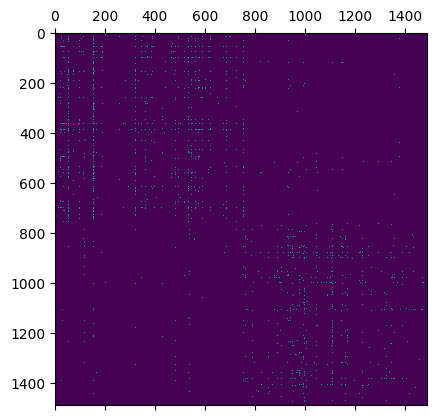

In [8]:
# Load graph dataset
polblogs_path = "../data/polblogs.mtx"

# Format is mtx, so we need to read it in a special way

# Load the graph
polblogs = mmread(polblogs_path)
plt.matshow(polblogs.todense())

In [5]:
import networkx as nx

# Use networkx to get the shortest path lengths
G = nx.from_scipy_sparse_array(polblogs)
dists = nx.floyd_warshall_numpy(G)

In [6]:
# from hyperdt.product_embed.product import ProductSpace
# from hyperdt.product_embed.embedding import embed

# ps = ProductSpace(dims=[2, 2, 2], curvatures=[-1, 0, 1])
# embeds = embed(dists[:20, :20], ps, print_freq=1)

In [7]:
# x_embed = torch.cat([component.embed_point(0.1 * torch.rand(20, component.dim)) for component in ps.components], axis=1)
# x_embed = torch.nan_to_num(x_embed, 0)

# d = [c.dist(x_i, y_i) for c, x_i, y_i in zip(ps.components, ps.split(x_embed), ps.split(x_embed))]
# [d_c.shape for d_c in d]

In [8]:
# !pip install geoopt

In [9]:
import geoopt
from tqdm.notebook import tqdm

In [10]:
# pm = ProductSpace(dims=[2, 2, 2], curvatures=[-1, 0, 1])
hyp = geoopt.Lorentz()
euc = geoopt.Euclidean()
sph = geoopt.Sphere()
pm = geoopt.ProductManifold((hyp, 3), (euc, 2), (sph, 3))

# Here's how you access individual manifolds:
for manifold in pm.manifolds:
    print(manifold, manifold.ndim)

Lorentz manifold 1
Euclidean(ndim=0) manifold 0
Sphere manifold 1


In [11]:
# Loss functions defined here

# Pairwise dists function
def pdist(x_embed):
    # n = x_embed.shape[0]
    # dists = torch.zeros((n, n), device=x_embed.device)
    # for i in range(n):
    #     for j in range(i + 1, n):
    #         dists[i, j] = pm.dist(x_embed[i], x_embed[j])
    # return dists
    return pm.dist2(x_embed[:, None], x_embed[None, :])


# Loss function
def loss(x_embed, dists, ignore_inf=True, random_subsample=None):
    if random_subsample:
        idx = torch.randperm(dists.shape[0])[:random_subsample]
        dists = dists[idx][:, idx]
        x_embed = x_embed[idx]

    n = dists.shape[0]
    idx = torch.triu_indices(n, n, offset=1)

    pdist_true = dists[idx[0], idx[1]]
    pdist_est = pdist(x_embed)[idx[0], idx[1]]

    if ignore_inf:
        non_inf = ~torch.isinf(pdist_true)
        pdist_true = pdist_true[non_inf]
        pdist_est = pdist_est[non_inf]

    return torch.sum(torch.abs((pdist_est / pdist_true) - 1))

# Loss function
def d_avg(x_embed, dists, ignore_inf=True, random_subsample=None):
    if random_subsample:
        idx = torch.randperm(dists.shape[0])[:random_subsample]
        dists = dists[idx][:, idx]
        x_embed = x_embed[idx]

    n = dists.shape[0]
    idx = torch.triu_indices(n, n, offset=1)

    pdist_true = dists[idx[0], idx[1]]
    pdist_est = pdist(x_embed)[idx[0], idx[1]]

    if ignore_inf:
        non_inf = ~torch.isinf(pdist_true)
        pdist_true = pdist_true[non_inf]
        pdist_est = pdist_est[non_inf]

    # Note that D_avg uses nonsquared distances:
    return torch.mean(torch.abs(pdist_est.sqrt() - pdist_true.sqrt()) / pdist_true)

# # Mean average precision (mAP) function
# def mean_average_precision(x_embed, graph, random_subsample=None):
#     """ 1 / |V| * sum_{a in V} 1 / deg(a) sum_{i=1}^{|N_a|} | N_a \cap R_{a, b_i}| / |R_{a, b_i}| """
#     if random_subsample:
#         idx = torch.randperm(graph.shape[0])[:random_subsample]
#         graph = graph[idx][:, idx]
#         x_embed = x_embed[idx]
    
#     dists = pdist(x_embed)
#     n = dists.shape[0]

#     total_precision = 0

#     for i in range(n):
#         neighbors = torch.argsort(dists[i])[:10]
#         neighbors = neighbors[neighbors != i]

#         # neighbors_true = torch.nonzero(graph[i]).flatten()
#         neighbors_true = torch.nonzero(graph[idx[i]] != 0).flatten()
#         deg_a = len(neighbors_true)

#         precision = 0
#         for neighbor in neighbors:
#             Ra_bi = set(neighbors[:neighbor + 1].tolist())
#             precision += len(set(neighbors_true.tolist()) & Ra_bi) / len(Ra_bi)

#         total_precision += precision / deg_a

#     return total_precision / n


In [12]:
# Params
N_POINTS = len(G)
BURN_IN_LR = 0.00001
BURN_IN_ITERS = 1000
LR = 0.01
ITERS = 1000
LOSS_WINDOW = 100
SUBSAMPLE = 32

# Randomly initialize embeddings
x_embed = torch.zeros(N_POINTS, 3 + 2 + 3, dtype=torch.float64, device=device)
x_embed[:, 0:3] = hyp.expmap0(
    torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 2)], dim=1)
)  # Random for hyperbolic (expmap0 is the exponential map at the origin)
x_embed[:, 3:5] = torch.randn(N_POINTS, 2)  # Random for Euclidean
x_embed[:, 5:8] = sph.expmap(
    x=torch.cat([torch.ones(N_POINTS, 1), torch.zeros(N_POINTS, 2)], dim=1),
    u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 2)], dim=1),
)  # Map to sphere
x_embed = geoopt.ManifoldParameter(x_embed, manifold=pm)

# Optimizer
opt = geoopt.optim.RiemannianAdam(params=[x_embed], lr=0.01)


# Get everything ready for torch
dists_torch = torch.tensor(dists[:N_POINTS, :N_POINTS], dtype=torch.float32, device=device)
my_tqdm = tqdm(total=BURN_IN_ITERS + ITERS)

# # First dists - verify it's not nan
# if torch.isnan(dists_torch).any():
#     print("dists_torch contains NaNs")
# elif torch.isnan(x_embed).any():
#     print("x_embed contains NaNs")
# elif torch.isnan(pdist(x_embed)).any():
#     print("pdists(x_embed) contains NaNs")
# elif torch.isnan(loss(x_embed, dists_torch, pm)).any():
#     print("loss(x_embed, dists_torch, pm) contains NaNs")

# # Check for infs as well
# elif torch.isinf(dists_torch).any():
#     print("dists_torch contains infs")
# elif torch.isinf(x_embed).any():
#     print("x_embed contains infs")
# elif torch.isinf(pdist(x_embed)).any():
#     print("pdists(x_embed) contains infs")
# elif torch.isinf(loss(x_embed, dists_torch, pm)).any():
#     print("loss(x_embed, dists_torch, pm) contains infs")

# Train loop
# else:
losses = []
for lr, n_iters in ((0.00001, BURN_IN_ITERS), (1, ITERS)):
    for i in range(n_iters):
        opt.zero_grad()
        l = loss(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE)
        l.backward()
        losses.append(l.item())
        if torch.isnan(l).any():
            print("l contains NaNs")
            break 
        opt.step()

        # TQDM management
        # Check mAP every 100 iterations
        # if i % 100 == 0:
        #     my_tqdm.set_postfix(mAP=f"{mean_average_precision(x_embed, polblogs):.4f}")
        my_tqdm.update(1)
        my_tqdm.set_description(f"Loss: {l.item():.4f}, Average Loss: {np.mean(losses[-LOSS_WINDOW:]):.4f}")


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/phil/miniconda3/envs/hdt/lib/python3.11/site-packages/geoopt/manifolds/lorentz/math.py:34: UserWarning: operator() profile_node %21 : int[] = prim::profile_ivalue(%19)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return _inner(u, v, keepdim=keepdim, dim=dim)


In [13]:
# Save the embeddings
x_embed.detach().numpy().dump(f"polblogs_embeddings_sub{SUBSAMPLE}.npy")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [14]:
# Sanity checks: do the norms work out?

torch.allclose((x_embed[:, 1:3] ** 2).sum(axis=1) - x_embed[:, 0] ** 2, torch.Tensor([-1]), atol=1e-4)
assert torch.allclose(x_embed[:, 5:8].norm(dim=1), torch.Tensor([1.0]), atol=1e-4)

RuntimeError: Double did not match Float

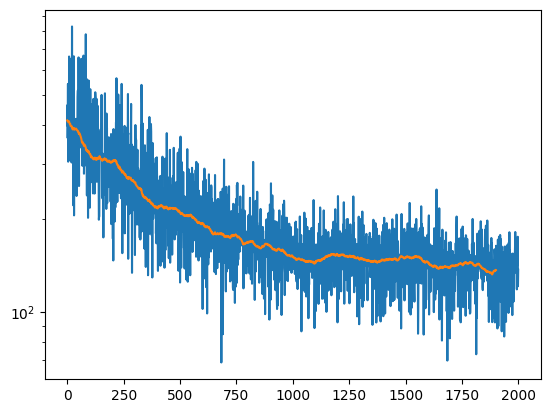

In [15]:
# Plot the losses
plt.plot(losses)
plt.plot(np.convolve(losses, np.ones(LOSS_WINDOW) / LOSS_WINDOW, mode="valid"))
plt.yscale("log")
plt.show()

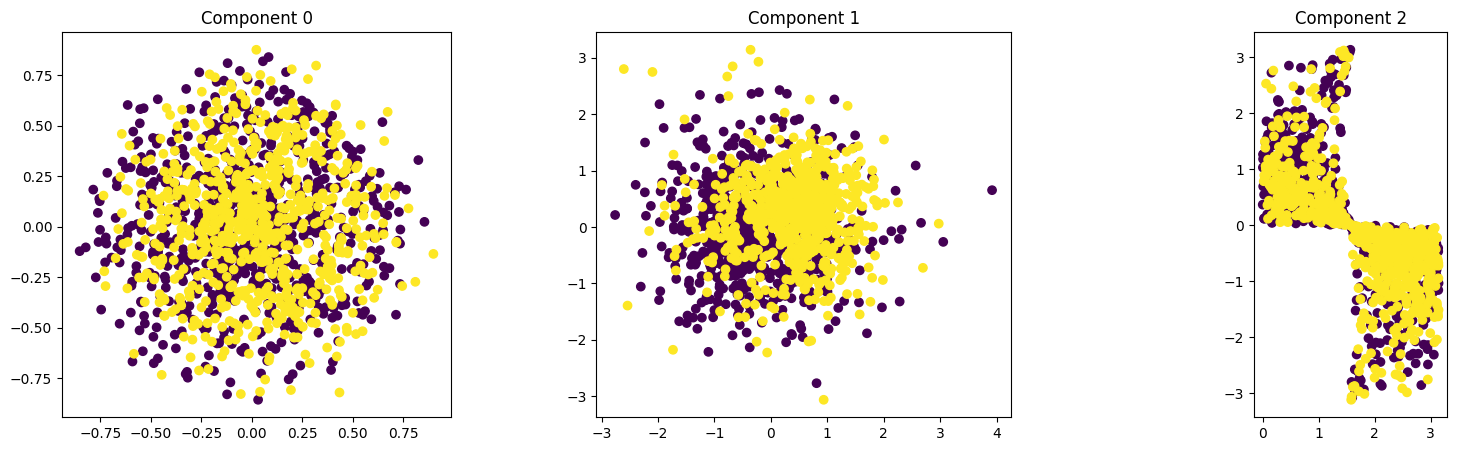

In [19]:
import pandas as pd

polblogs_labels = pd.read_table("../data/polblogs_labels.tsv", header=None)[0][:N_POINTS]


def hyperboloid_to_poincare(X):
    # Spatial components: all columns except the first
    x_space = X[:, 1:]

    # Time-like component: first column, reshaped for broadcasting
    x_time = X[:, 0:1]

    # Convert to Poincaré ball coordinates
    poincare_coords = x_space / (1 + x_time)

    return poincare_coords


def spherical_to_polar(X):
    # Radius computation
    r = torch.norm(X, dim=1, keepdim=True)

    # Prepare output tensor
    out = torch.zeros_like(X)
    out[:, 0] = r.squeeze()  # Set the radius

    # Compute angles
    for i in range(1, X.size(1)):
        if i == X.size(1) - 1:
            # Last angle, use atan2 for full 360 degree
            out[:, i] = torch.atan2(X[:, i - 1], X[:, i - 2])
        else:
            # Compute angle from the higher dimension 'hypotenuse'
            hypotenuse = torch.norm(X[:, i:], dim=1, keepdim=True)
            # Prevent division by zero
            safe_hypotenuse = torch.where(hypotenuse > 0, hypotenuse, torch.tensor(1.0).to(X.device))
            # Ensure acos receives values within [-1, 1] and preserve dimensions
            angle = torch.acos(torch.clamp(X[:, i : i + 1] / safe_hypotenuse, -1, 1))
            out[:, i] = angle.squeeze()

    return out[:, 1:]


# Plot each component of the embeddings
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    if i == 0:  # hyperboloid --> poincare
        x = hyperboloid_to_poincare(x_embed[:, 0:3])
    elif i == 1:
        x = x_embed[:, 3:5]
    elif i == 2:  # spherical --> polar
        x = spherical_to_polar(x_embed[:, 5:8])
    x = x.detach().cpu().numpy()
    ax.scatter(x[:, 0], x[:, 1], c=polblogs_labels)
    ax.set_title(f"Component {i}")
    ax.set_aspect("equal")

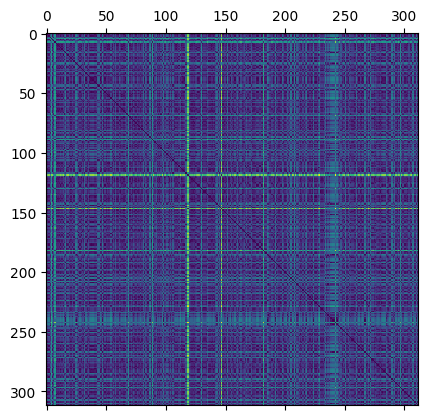

In [12]:
# Confirm that we can embed cities dataset

# cities_dists = torch.zeros((312*312,), device=device)
dists_flattened = []
with open("../data/cities.txt") as f:
    for line in f:
        if line.startswith("#"):
            continue
        dists_flattened += [float(x) for x in line.split()]

cities_dists = torch.tensor(dists_flattened, device=device).reshape(312, 312)
# cities_dists /= cities_dists.max()

plt.matshow(cities_dists.cpu().detach().numpy())

In [27]:
# Train

# Params
N_POINTS = 312
BURN_IN_LR = 0.01
BURN_IN_ITERS = 1000
LR = 0.1
ITERS = 19000
LOSS_WINDOW = 100
SUBSAMPLE = None

# Use S5 x S5
# r1 = torch.nn.Parameter(torch.tensor([1.0], device=device))
# r2 = torch.nn.Parameter(torch.tensor([1.0], device=device))
pm = geoopt.ProductManifold((geoopt.Scaled(sph, 1.0, learnable=True), 6), (geoopt.Scaled(sph, 1.0, learnable=True), 6))

# Randomly initialize embeddings
x_embed = torch.zeros(N_POINTS, 6 + 6, dtype=torch.float64, device=device)
x_embed[:, 0:6] = sph.expmap(
    x=torch.cat([torch.ones(N_POINTS, 1), torch.zeros(N_POINTS, 5)], dim=1),
    u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 5)], dim=1),
)  # Map to sphere
x_embed[:, 6:12] = sph.expmap(
    x=torch.cat([torch.ones(N_POINTS, 1), torch.zeros(N_POINTS, 5)], dim=1),
    u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, 5)], dim=1),
)  # Map to sphere
x_embed = geoopt.ManifoldParameter(x_embed, manifold=pm)

# Optimizer
opt = geoopt.optim.RiemannianAdam(params=[x_embed, pm.manifolds[0]._log_scale, pm.manifolds[1]._log_scale], lr=0.01)

# Get everything ready for torch
dists_torch = torch.tensor(cities_dists, dtype=torch.float32, device=device)
my_tqdm = tqdm(total=BURN_IN_ITERS + ITERS)

# Train loop
losses = []
for lr, n_iters in ((BURN_IN_LR, BURN_IN_ITERS), (LR, ITERS)):
    # Set the learning rate
    opt.param_groups[0]["lr"] = lr
    for i in range(n_iters):
        opt.zero_grad()
        l = loss(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE)
        l.backward()
        losses.append(l.item())
        if torch.isnan(l).any():
            print("l contains NaNs")
            break 
        opt.step()

        # TQDM management
        my_tqdm.update(1)
        my_tqdm.set_description(f"Loss: {l.item():.4e}, Average Loss: {np.mean(losses[-LOSS_WINDOW:]):.4e}")

        if i % 50 == 0:
            my_tqdm.set_postfix(
                {
                    "d_avg": f"{d_avg(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE).item():.3f}", 
                    "r1": f"{pm.manifolds[0]._log_scale.item():.3f}", 
                    "r2": f"{pm.manifolds[1]._log_scale.item():.3f}"
                }
            )

/tmp/ipykernel_830030/4280016032.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dists_torch = torch.tensor(cities_dists, dtype=torch.float32, device=device)


  0%|          | 0/20000 [00:00<?, ?it/s]

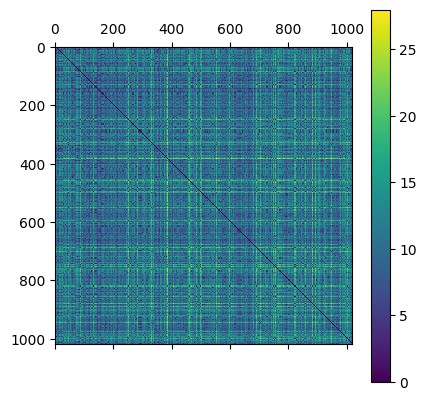

In [45]:
# Confirm that we can embed cities dataset

# cities_dists = torch.zeros((312*312,), device=device)
# dists_flattened = []
# with open("../data/cs_phds.txt") as f:
#     for line in f:
#         if line.startswith("#"):
#             continue
#         dists_flattened += [float(x) for x in line.split()]

G = nx.read_pajek("../data/cs_phds.txt").to_undirected()
phd_dists = nx.floyd_warshall_numpy(G.subgraph(max(nx.connected_components(G), key=len)))
# phd_dists = torch.tensor(dists_flattened, device=device).reshape(312, 312)
# cities_dists /= cities_dists.max()

plt.matshow(phd_dists)
plt.colorbar()
plt.show()

In [ ]:
def resample(x_embed, nan_rows, pm, dims, man2dim, device):
    for row in nan_rows.unique():
        # Which manifolds need to be reset?
        nan_cols = torch.where(torch.isnan(x_embed[row]))[0]
        for man in set([dim2man[col.item()] for col in nan_cols]):
            d = signature[man][1]
            # Reset the (row, manifold) component
            if signature[man][0] < 0:
                new_vals = hyp.expmap0(u=torch.cat([torch.zeros(1), torch.randn(d)], dim=0))
            elif signature[man][0]  == 0:
                new_vals = torch.randn(d)
            else:
                new_vals = sph.expmap(
                    x=torch.cat([torch.ones(1), torch.zeros(d)], dim=0),
                    u=torch.cat([torch.zeros(1), torch.randn(d)], dim=0),
                )
            x_embed[row, man2dim[man]] = new_vals.to(device)
            print(f"Reset row {row}, manifold {man}")

In [16]:
# That's pretty close to their reported number of D_avg = .0593
# Will (H2)^2 x E2 x (S2)^2 give us 0.0765?
# Will (S2)^5 give us 0.0638? --> No, we actually get .024
from tqdm import tqdm

# Params
DATASET = cities_dists
N_POINTS = len(DATASET)
BURN_IN_LR = 1e-3
BURN_IN_ITERS = 2000
LR = 1e-2
ITERS = 18000
LOSS_WINDOW = 100
SUBSAMPLE = None
CLIP_MAX = False
SCALE = True
CLIP_GRAD = False

# signature = [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]
# signature = [(-1, 2)]#, (-1, 5)]
# signature = [(-1, 5), (-1, 5)] # (H2)^5 - .036 on CS PhDs
signature = [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)]

components, dims = [], []
curr_dim, curr_man = 0, 0
dim2man, man2dim = {}, {}

for curv, dim in signature:
    if curv < 0:
        components.append(geoopt.Scaled(hyp, 1/abs(curv), learnable=True))
    elif curv == 0:
        components.append(geoopt.Scaled(euc, 1.0, learnable=True))
    elif curv > 0:
        components.append(geoopt.Scaled(sph, 1/abs(curv), learnable=True))
    
    ambient_dim = dim if curv == 0 else dim + 1
    dims.append(ambient_dim)
    
    for d in range(curr_dim, curr_dim + ambient_dim):
        dim2man[d] = curr_man
    man2dim[curr_man] = list(range(curr_dim, curr_dim + ambient_dim))
    
    curr_dim += ambient_dim
    curr_man += 1

pm = geoopt.ProductManifold(*zip(components, dims))

x_embed = []
for curv, dim in signature:
    if curv < 0:
        x_embed.append(
            hyp.expmap0(u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, dim)], dim=1))
        )
    elif curv == 0:
        x_embed.append(torch.randn(N_POINTS, dim))
    elif curv > 0:
        x_embed.append(
            sph.expmap(
                x=torch.cat([torch.ones(N_POINTS, 1), torch.zeros(N_POINTS, dim)], dim=1),
                u=torch.cat([torch.zeros(N_POINTS, 1), torch.randn(N_POINTS, dim)], dim=1),
            )
        )
    else:
        raise ValueError("Unknown manifold type")

x_embed = torch.cat(x_embed, axis=1).to(device)
x_embed = geoopt.ManifoldParameter(x_embed, manifold=pm)

# Optimizer
# if SCALE:
#     opt = geoopt.optim.RiemannianAdam(params=[x_embed] + [x._log_scale for x in pm.manifolds], lr=BURN_IN_LR)
# else: 
opt = geoopt.optim.RiemannianAdam(params=[x_embed], lr=BURN_IN_LR)

# Get everything ready for torch
dists_torch = torch.tensor(DATASET, dtype=torch.float32, device=device)
if CLIP_MAX:
    dists_torch = dists_torch.clip(0, dists_torch[torch.isfinite(dists_torch)].max())
dists_torch /= dists_torch.max() # Normalize
my_tqdm = tqdm(total=BURN_IN_ITERS + ITERS)

# Train loop
losses, exp_avg_means = [], []
early_stopping_tracker = []
for lr, n_iters in ((BURN_IN_LR, BURN_IN_ITERS), (LR, ITERS)):
    # Set the learning rate
    opt.param_groups[0]["lr"] = lr
    if SCALE and lr == LR:
        # Add the scale parameters to the optimizer
        opt.add_param_group({"params": [x._log_scale for x in pm.manifolds], "lr": LR})
    for i in range(n_iters):
        # Complicated NaN resampling logic
        with torch.no_grad():
            nan_rows = torch.where(torch.isnan(x_embed))[0]
            if len(nan_rows) > 0:
                break
                resample(x_embed, nan_rows, pm, dims, man2dim, device)
        opt.zero_grad()
        l = loss(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE)
        l.backward()
        losses.append(l.item())

        if CLIP_GRAD:
            torch.nn.utils.clip_grad_norm_(x_embed, 1.0)
        opt.step()
        exp_avg_means.append(opt.state[x_embed]["exp_avg"].mean().item())

        # TQDM management
        my_tqdm.update(1)
        my_tqdm.set_description(f"Loss: {l.item():.3e}, Average Loss: {np.mean(losses[-LOSS_WINDOW:]):.3e}")

        if i % 50 == 0:
            d = {f"r{i}": f"{x._log_scale.item():.3f}" for i, x in enumerate(pm.manifolds)}
            d["d_avg"] = f"{d_avg(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE).item():.4f}"
            my_tqdm.set_postfix(d)

            # Early stopping stuff
            early_stopping_tracker.append(d_avg(x_embed, dists_torch, pm, random_subsample=SUBSAMPLE).item())
            if len(early_stopping_tracker) >= 10 and all([x > early_stopping_tracker[-1] for x in early_stopping_tracker[-10:]]):
                print("Early stopping!")
                break

/tmp/ipykernel_1077411/2494404707.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dists_torch = torch.tensor(DATASET, dtype=torch.float32, device=device)



Loss: 8.893e+06, Average Loss: 9.535e+06:   1%|          | 174/20000 [36:20<69:00:16, 12.53s/it, r0=0.000, r1=0.000, r2=0.000, r3=0.000, r4=0.000, d_avg=41.0692]

























































KeyboardInterrupt: 

In [115]:
def dist_component_by_manifold(pm, x_embed):
    """ How much of the variance in distance is explained by each manifold? """
    sq_dists_by_manifold = [
        man.dist2(
            x_embed[:, man2dim[i]][:, None, :], 
            x_embed[:, man2dim[i]][None, :, :]
        ) for i, man in enumerate(pm.manifolds)
    ]
    total_sq_dist = pm.dist2(x_embed[:, None], x_embed[None, :])
 
    return [
        (torch.sum(sq_dists_by_manifold[i]) / torch.sum(total_sq_dist)).item() for i in range(len(pm.manifolds))
    ]

dist_component_by_manifold(pm, x_embed)

KeyError: 0

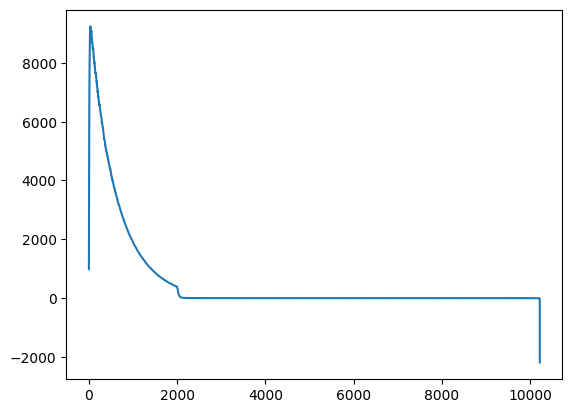

In [168]:
plt.plot(exp_avg_means)

In [1]:
import geoopt

sph = geoopt.Sphere()

In [4]:
sph.random_uniform(312, 6).shape

torch.Size([312, 6])